In [1]:
from create_datasets import read_json_dataset
from dict_utils import unfold_to_list, fold_from_list
from pipeline import Pipeline, FewShotPipeline

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")


def add_lerc_preds(data, lerc_preds_dir, split):
    lerc_preds = read_json_dataset(lerc_preds_dir, split)
        
    for dataset, d in lerc_preds.items():
        for example_id, score in d.items():
            data[dataset][example_id]["LERC"] = (score["pred_score"] - 1) / (5-1)
            
    return data

In [2]:
DATASET_DIR = "../data/lr_experiments"
LERC_PREDS_DIR = f"{DATASET_DIR}/lerc_preds"

train = read_json_dataset(DATASET_DIR, "train_metrics")
dev = read_json_dataset(DATASET_DIR, "dev_metrics")
test = read_json_dataset(DATASET_DIR, "test_metrics")
print(len(train), len(dev), len(test))

add_lerc_preds(dev, LERC_PREDS_DIR, "dev")
add_lerc_preds(test, LERC_PREDS_DIR, "test")

train_df = pd.DataFrame(unfold_to_list(train, "dataset", "example_id"))
dev_df   = pd.DataFrame(unfold_to_list(dev, "dataset", "example_id"))
test_df  = pd.DataFrame(unfold_to_list(test, "dataset", "example_id"))
print(train_df.shape, dev_df.shape, test_df.shape)

train_df["score_scaled"] = train_df.score.apply(lambda s: (s-1)/(5-1))
dev_df["score_scaled"] = dev_df.score.apply(lambda s: (s-1)/(5-1))
test_df["score_scaled"] = test_df.score.apply(lambda s: (s-1)/(5-1))

6 6 6
(31069, 48) (4009, 49) (6321, 49)


In [3]:
DATASETS = list(train.keys())

METRICS = [
    # Bleu
    'bleu1', 'bleu2', 'bleu3', 'bleu4', 
    # 'hf_bleu1', 'hf_bleu2', 'hf_bleu3', 'hf_bleu4', 
    'rougeL', 
    # 'hf_rougeL', 'hf_rougeLsum',
    'hf_rouge1', 'hf_rouge2',
    'meteor',
    'recall', 'precision', 'f1_score',
    'sari_context', 'sari_question',
    # Token overlap when 1st error occurred
    'precision_at_err1', 'recall_at_err1',
    # Confusion matrix
    'tp', 'fn', 'fp',
    # Edit scores ------
    'char_edit_score', 'word_edit_score',
    # Learned metrics -------
    'bertscore', 'bleurt',
    # Input statistics ------
    'candidatelength_word', 'candidatelength_char',
    'candidatenunique_words', 'referencelength_word',
    'referencelength_char', 'referencenunique_words',
    'contextlength_word', 'contextlength_char',
    'contextnunique_words', 'questionlength_word',
    'questionlength_char', 'questionnunique_words',
]

TARGET = "score_scaled"

**Validate numbers reported in original MOCHA paper**

Most of the values are close to the numbers reported in the paper. The ones that are not, are consistently higher.

In [4]:
from scipy.stats import pearsonr

for dataset in DATASETS:
    print(); print("---- DEV SET ----")
    _df = dev_df[dev_df.dataset == dataset]
    print(dataset, "bleu1", round(pearsonr(_df["score_scaled"], _df["bleu1"])[0], 3))
    print(dataset, "meteor", round(pearsonr(_df["score_scaled"], _df["meteor"])[0], 3))
    print(dataset, "rougeL", round(pearsonr(_df["score_scaled"], _df["rougeL"])[0], 3))
    print(dataset, "bert-score", round(pearsonr(_df["score_scaled"], _df["bertscore"])[0], 3))
    print()
    
    print("TEST SET")
    _df = test_df[test_df.dataset == dataset]
    print(dataset, "bleu1", round(pearsonr(_df["score_scaled"], _df["bleu1"])[0], 3))
    print(dataset, "meteor", round(pearsonr(_df["score_scaled"], _df["meteor"])[0], 3))
    print(dataset, "rougeL", round(pearsonr(_df["score_scaled"], _df["rougeL"])[0], 3))
    print(dataset, "bert-score", round(pearsonr(_df["score_scaled"], _df["bertscore"])[0], 3))
    print()


---- DEV SET ----
cosmosqa bleu1 0.66
cosmosqa meteor 0.697
cosmosqa rougeL 0.702
cosmosqa bert-score 0.805

TEST SET
cosmosqa bleu1 0.671
cosmosqa meteor 0.712
cosmosqa rougeL 0.701
cosmosqa bert-score 0.78


---- DEV SET ----
drop bleu1 0.409
drop meteor 0.664
drop rougeL 0.48
drop bert-score 0.174

TEST SET
drop bleu1 0.388
drop meteor 0.568
drop rougeL 0.366
drop bert-score 0.329


---- DEV SET ----
mcscript bleu1 0.182
mcscript meteor 0.461
mcscript rougeL 0.225
mcscript bert-score 0.173

TEST SET
mcscript bleu1 0.261
mcscript meteor 0.503
mcscript rougeL 0.297
mcscript bert-score 0.195


---- DEV SET ----
narrativeqa bleu1 0.403
narrativeqa meteor 0.606
narrativeqa rougeL 0.434
narrativeqa bert-score 0.419

TEST SET
narrativeqa bleu1 0.472
narrativeqa meteor 0.616
narrativeqa rougeL 0.496
narrativeqa bert-score 0.535


---- DEV SET ----
quoref bleu1 0.675
quoref meteor 0.729
quoref rougeL 0.713
quoref bert-score 0.208

TEST SET
quoref bleu1 0.578
quoref meteor 0.716
quoref rouge

# Regression Experiments

In [5]:
# ----------------------------------------
# TODO LIST
# ----------------------------------------
# - [x] Match Pearson results w/ MOCHA paper 
#      (still do not match 100% -- why?)
# - [] Understand each metric
# - [] Differences in implementations (pycoco vs hf)
# - [x] LR
# - [x] LR LOO base experiment (no few shot)
# - [x] L1
# - [x] RF Experiments
# - [x] LR LOO base experiment (w/ few shot)
# - [] LR w/ PCA
# - [x] Understand Bayesian LR (MML)
# - [] Understand PCA
# - [] Read paper

In [6]:
def get_subset(df, dataset = None, col="dataset"):
    return df[df[col] == dataset].copy() if dataset else df
    
def get_all_datasets(df, datasets, include_all=True):
    result = {} if not include_all else {"all": df.copy()}
    
    for dataset in datasets:
        result.update({dataset: get_subset(df, dataset)})
        
    return result

def get_loov_datasets(df, datasets):
    result = {}

    for dataset in datasets:
        loo_datasets = [get_subset(df, d) for d in datasets if d != dataset]
        loo_dataset = pd.concat(loo_datasets)
        
        result.update({f"except_{dataset}": loo_dataset})
        
    return result

TRAIN_DATASETS = get_all_datasets(train_df, DATASETS)
DEV_DATASETS   = get_all_datasets(dev_df, DATASETS)
TEST_DATASETS  = get_all_datasets(test_df, DATASETS)

TRAIN_LOO_DATASETS = get_loov_datasets(train_df, DATASETS)

# For baselines and individual metrics (and to avoid duplicating code)
# we may be interested in using "LERC" as a feature (e.g., baseline)
# To re-use the pipeline code, we will create a dummy variable with 
# LERC values of -1 for the dataset.
import copy
TRAIN_DATASETS_DUMMY_LERC = copy.deepcopy(TRAIN_DATASETS)

for dataset in TRAIN_DATASETS_DUMMY_LERC.values(): 
    dataset["LERC"] = -1
    
# Finally, we do a sanity check to ensure the original training set was
# not modified:
assert any("LERC" in d.columns for d in TRAIN_DATASETS.values()) == False

## Understand each metric (TODO)

## Differences in implementation (PyCOCO vs HF)

[__pyCOCOEvalCap__](https://github.com/salaniz/pycocoevalcap): 

[__HuggingFace__.datasets.metrics]: 

## Baseline experiments

In [7]:
from sklearn.linear_model import LinearRegression

In [8]:
def fit(
        model_class,
        model_hparams,
        features,
        target,
        train_datasets,
        split_frac=None,
        with_std=True,
        with_pca=False,
        seed=817237,
        pipeline_class=Pipeline,
    ) -> dict:
    pipelines = {}
    
    for train_name, train_data in train_datasets.items():
        pipeline = pipeline_class(model_class, model_hparams, train_name, features, target, seed=seed)
        pipeline.load_data(train_data)
        if split_frac and isinstance(split_frac, float):
            pipeline.split(holdout_fraction=split_frac)

        pipeline.preprocess(with_std=with_std, with_pca=with_pca)
        pipeline.fit()
        pipelines[train_name] = pipeline

    return pipelines


def evaluate(pipelines, eval_datasets):
    results = []
    for train_name, pipeline in pipelines.items():
        result = pipeline.evaluate_multiple(eval_datasets)
        results.extend(result)
    return results

def evaluate_loo(pipelines, eval_datasets):
    results = []
    for train_name, pipeline in pipelines.items():
        loo_dataset = train_name.rpartition("_")[-1]
        result = pipeline.evaluate_multiple({loo_dataset: eval_datasets[loo_dataset]})
        results.extend(result)

    return results

### Individual metrics

In [ ]:
class IndividualMetric:
    def __init__(self, feature=None):
        self.feature = feature
                
    def fit(self, X, y):
        pass
    
    def predict(self, X):
        if self.feature is None:
            raise RuntimeError("No feature specified")

        y_pred = X[self.feature]
        
        assert len(y_pred) == X.shape[0]
        return y_pred


In [ ]:
individual_results = []
for metric in ["LERC"] + METRICS: 
    ps = fit(IndividualMetric, {"feature": metric}, [metric], TARGET, {"all": TRAIN_DATASETS_DUMMY_LERC["all"]}, with_pca=False, with_std=False)
    results = evaluate(ps, DEV_DATASETS)
    for r in results:
        r["model_classpath"] = metric
    
    individual_results.extend(results)

individual_results = pd.DataFrame(individual_results)
individual_results.head()

In [ ]:
individual_results.to_csv("results/baseline_individual.csv")

### Average

In [ ]:
class AverageBaseline:
    def __init__(self, features=None, subset=None):
        if features is None or subset is None:
            self.features = None
            self.subset = None
            self.subset_feat_ids = None
        else:
            self.features = features
            self.subset = subset        
            self.subset_feat_ids = [i for i, f in enumerate(features) if f in subset]
                
    def fit(self, X, y):
        pass
    
    def predict(self, X):
        if self.features is not None:
            X = X[:, self.subset_feat_ids]
        else:
            print("Since no features were specified, using all input to make prediction")

        y_pred = np.mean(X, axis=1)
        assert len(y_pred) == X.shape[0]
        return y_pred

In [ ]:
# All datasets experiment
ad_avg_all_pipelines = fit(AverageBaseline, {}, METRICS, TARGET, TRAIN_DATASETS)
ad_avg_all_results = evaluate(ad_avg_all_pipelines, DEV_DATASETS)
ad_avg_all_results = pd.DataFrame(ad_avg_all_results)
ad_avg_all_results.to_csv("results/baseline_avg_all.csv")
ad_avg_all_results.head()

In [ ]:
# TODO
# Learn avg in training and predict that

### Linear Regression

In [ ]:
# All datasets experiment
ad_lr_pipelines = fit(LinearRegression, {}, METRICS, TARGET, TRAIN_DATASETS)
ad_lr_results = evaluate(ad_lr_pipelines, DEV_DATASETS)
ad_lr_results = pd.DataFrame(ad_lr_results)
ad_lr_results.to_csv("results/ad_lr.csv")

loo_lr_pipelines = fit(LinearRegression, {}, METRICS, TARGET, TRAIN_LOO_DATASETS)
loo_lr_results = evaluate(loo_lr_pipelines, DEV_DATASETS)
loo_lr_results = pd.DataFrame(loo_lr_results)
loo_lr_results.to_csv("results/loo_lr.csv")

# All (baseline) LR results
lr_results = pd.concat((ad_lr_results, loo_lr_results)).reset_index(drop=True)
# lr_results.to_csv("results/lr.csv")

lr_results.head()

## L1 Regression (Lasso Regression)

In [ ]:
from sklearn.linear_model import Lasso

from sklearn.model_selection import ParameterSampler
from scipy.stats import expon


def get_alpha(args):
    return eval(args)["alpha"]


def plot_metric_by_alpha(data, metric, **kwargs):
    n_plots = data.trained_on.nunique()
    n_cols = 3

    n_rows = n_plots // n_cols
    n_rows += n_plots % n_cols

    position = range(1, n_plots+1)

    fig = plt.figure(1, figsize=(10, 10), dpi=150)

    for k, trained_on in enumerate(data.trained_on.unique()):
        d = data[(data["trained_on"] == trained_on)]
        ax = fig.add_subplot(n_rows, n_cols, position[k])
        sns.lineplot(data=d, x="alpha", y=metric, ax=ax, **kwargs)
        ax.set_title(f"Trained_on={trained_on}")

    plt.tight_layout()

In [ ]:
# We will perform model selection using L1 regression
# since it is known to enforce sparsity of the solution!
N_L1_MODELS = 100

L1_GRID = {'alpha': expon(loc=0, scale=0.20)}
L1_PARAMS = list(ParameterSampler(L1_GRID, n_iter=N_L1_MODELS, random_state=81723))

plt.figure(figsize=(5, 3), dpi=150)
plt.hist([p["alpha"] for p in L1_PARAMS])
plt.title("Distribution of the sampled alpha values for Lasso")
plt.savefig("results/l1_alphas_dist.png", dpi=150)
plt.show()

In [ ]:
l1_pipelines = {}
ad_results = []
loo_results = []
for i, l1_hparams in enumerate(L1_PARAMS):
    if l1_hparams["alpha"] > 2:
        continue

    # All datasets experiment
    ad_l1_pipelines = fit(Lasso, l1_hparams, METRICS, TARGET, TRAIN_DATASETS)
    ad_l1_results = evaluate(ad_l1_pipelines, DEV_DATASETS)
    ad_l1_results = pd.DataFrame(ad_l1_results)
    ad_l1_results["i"] = i
    ad_results.append(ad_l1_results)

    loo_l1_pipelines = fit(Lasso, l1_hparams, METRICS, TARGET, TRAIN_LOO_DATASETS)
    # loo_l1_results = evaluate(loo_l1_pipelines, DEV_DATASETS)
    loo_l1_results = evaluate_loo(loo_l1_pipelines, DEV_DATASETS)
    loo_l1_results = pd.DataFrame(loo_l1_results)
    loo_l1_results["i"] = i
    loo_results.append(loo_l1_results)

    # All (baseline) LR results
    l1_pipelines[i] = {"AD": ad_l1_pipelines, "LOO": loo_l1_pipelines}
    
l1_ad_results = pd.concat(ad_results).reset_index(drop=True)
l1_ad_results["alpha"] = l1_ad_results["model_hparams"].apply(get_alpha)

l1_loo_results = pd.concat(loo_results).reset_index(drop=True)
l1_loo_results["alpha"] = l1_loo_results["model_hparams"].apply(get_alpha)

In [ ]:
def get_feat_information(pipelines, results, experiment_type, metrics):
    results = results.copy()
    # For every set of experiments
    for i, experiments in pipelines.items():
        # Get the experiment_type pipeline (AD or LOO)
        for trained_on, pipeline in experiments[experiment_type].items():
            # Determine the important features and their importance
            _feat_importance = pipeline.model.coef_
            _mask = np.abs(_feat_importance) > 1e-6
            
            trained_on_mask = results["trained_on"] == trained_on
            i_mask = results["i"] == i

            _feats = np.argsort(np.abs(_feat_importance))[::-1]
            _featnames = tuple(metrics[ix] for ix in _feats if _mask[ix])
            _feats = {metrics[ix]: _feat_importance[ix] for ix in _feats if _mask[ix]}
            _feats["intercept_"] = pipeline.model.intercept_

            results.loc[trained_on_mask & i_mask, "n_features"] =  sum(_mask)
            results.loc[trained_on_mask & i_mask, "feat_names"] = str(_featnames)
            results.loc[trained_on_mask & i_mask, "feat_importance"] = str(_feats)

    return results


l1_ad_results = get_feat_information(l1_pipelines, l1_ad_results, "AD", METRICS)
l1_ad_results.to_csv("results/l1_ad.csv")

l1_loo_results = get_feat_information(l1_pipelines, l1_loo_results, "LOO", METRICS)
l1_loo_results.to_csv("results/l1_loo.csv")

In [ ]:
plot_metric_by_alpha(l1_ad_results, "mse")
plt.savefig("results/l1_ad_avg_mse_by_alpha.png", dpi=200)

In [ ]:
plot_metric_by_alpha(l1_ad_results, "mse", hue="evaluated_on")
plt.savefig("results/l1_ad_mse_by_alpha_discriminated_by_evaluation_set.png", dpi=200)

In [ ]:
plot_metric_by_alpha(l1_loo_results, "mse", hue="evaluated_on")
plt.savefig("results/l1_loo_mse_by_alpha_discriminated_by_evaluation_set.png", dpi=200)

## Random Forest experiments

In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
# All datasets experiment
ad_rf_def_pipelines = fit(RandomForestRegressor, {}, METRICS, TARGET, TRAIN_DATASETS)
ad_rf_def_results = evaluate(ad_rf_def_pipelines, DEV_DATASETS)
ad_rf_def_results = pd.DataFrame(ad_rf_def_results)
ad_rf_def_results.to_csv("results/ad_rf.csv")

loo_rf_def_pipelines = fit(RandomForestRegressor, {}, METRICS, TARGET, TRAIN_LOO_DATASETS)
loo_rf_def_results = evaluate(loo_rf_def_pipelines, DEV_DATASETS)
loo_rf_def_results = pd.DataFrame(loo_rf_def_results)
loo_rf_def_results.to_csv("results/loo_rf.csv")

# All (baseline) LR results
rf_def_results = pd.concat((ad_rf_def_results, loo_rf_def_results)).reset_index(drop=True)
rf_def_results

## Few shot experiment 

We can perform this experiment in multiple ways. It considers the LOO experiment. 
We can use weight the training data differently, and we can use different number of examples in the LOO experiment.

For the first experiment, we will consider using all the available training data ($100\%$) and use different number of points in the LOO. In order to ensure comparable results, we will restrict our _few shot_ examples to the ones available in the training split (that weren't used in the first place) and we evaluate on the same development set. Future experiments may consider enlarging it and using more examples from the dev set.


In general, we devise the following steps for a few-shot experiment:
1. create dataset of $D_{PT}=(D_1, ..., D_5)$;
2. train __model__ $m$ in $D_{PT}$;
3. assign weight $w_{PT}$ to examples used in pre-training according to ratio $\tau$;
3. select a fraction of the examples $f$ from $D_6$;
4. assign weight $w_{FS}$ to the fraction of $D_6$ examples according to ratio $\tau$;
5. train __model__
6. evaluate in dev set for $D_6$
5. repeat evaluation for 20 seeds.

In [9]:
# Weighting scheme proof of concept
n1, n2 = 24_000, 1000
n = n1 + n2

# If we want n1 examples to be equivalent to a
# of the total dataset, then:
a = 0.2
target_n1, target_n2 = n * a, n * (1-a)
n1_w = target_n1 / n1 
n2_w = target_n2 / n2
print(n1_w, n2_w)

0.20833333333333334 20.0


In [10]:
class FewShotPipeline(Pipeline):
    def __init__(self, fewshot_dataset, fewshot_weight, **kwargs):
        super().__init__(**kwargs)
        self.fewshot_dataset = fewshot_dataset
        # pre-training to fewshot weight
        # a value of 0.1 implies that the fewshot dataset
        # worths 10% of the dataset and the pretraining set is worth 90%
        assert fewshot_weight is None or 0 < fewshot_weight < 1, "fewshot_weight should be in (0, 1)"
        self.fewshot_weight = fewshot_weight
        
    def load_data(self, data, fewshot_data):
        super().load_data(data)
        self.X_train_orig = self.X_train.copy()
        
        print(f"Loading **fewshot** dataset '{self.fewshot_dataset}':", fewshot_data.dataset.unique())
        self.X_fewshot = fewshot_data[self.features]
        self.y_fewshot = fewshot_data[self.target]
        
    def _compute_weights(self, n_fewshot, n_ptrain):
        if self.fewshot_weight is None:
            return 1, 1

        n = n_ptrain + n_fewshot
        target_fewshot = self.fewshot_weight * n
        target_ptrain  = (1-self.fewshot_weight) * n
        
        fewshot_weight = target_fewshot / n_fewshot
        ptrain_weight  = target_ptrain / n_ptrain
        
        return fewshot_weight, ptrain_weight
        
    def fewshot_fit(self): # TODO - Preprocessing should consider the instances we use (including the weight)        
        fewshot_n, ptrain_n = len(self.X_fewshot), len(self.X_train)
        fewshot_w, ptrain_w = self._compute_weights(fewshot_n, ptrain_n)
        
        weights = np.ones(fewshot_n+ptrain_n)
        weights[:ptrain_n] *= ptrain_w
        weights[ptrain_n:] *= fewshot_w

        X = np.vstack((self.X_train, self.X_fewshot))
        y = np.concatenate((self.y_train, self.y_fewshot))
        self.X_train = X
        
        # Preprocessing 
        self.preprocess() # modifies self.X_train inplace

        self.model = self.model_class(**self.model_hparams)
        self.model.fit(self.X_train, y, sample_weight=weights)
        
        self.X_train = self.X_train_orig
        
        
fs_pipeline = FewShotPipeline(
    fewshot_dataset="cosmosqa",
    fewshot_weight=0.6,
    model_class=LinearRegression,
    model_hparams={},
    dataset="except_cosmosqa",
    features=METRICS,
    target=TARGET,
)

fs_pipeline.load_data(TRAIN_LOO_DATASETS["except_cosmosqa"], fewshot_data=TRAIN_DATASETS["cosmosqa"])
fs_pipeline.fewshot_fit()
# TRAIN_LOO_DATASETS
fs_pipeline.evaluate_multiple(DEV_DATASETS)

Loading dataset 'except_cosmosqa': ['drop' 'mcscript' 'narrativeqa' 'quoref' 'socialiqa']
Loading **fewshot** dataset 'cosmosqa': ['cosmosqa']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

[{'mse': 0.06456814522808375,
  'r2': 0.5400236794508155,
  'pearson': 0.7352893278875137,
  'spearman': 0.722429450665985,
  'features': ['bleu1',
   'bleu2',
   'bleu3',
   'bleu4',
   'rougeL',
   'hf_rouge1',
   'hf_rouge2',
   'meteor',
   'recall',
   'precision',
   'f1_score',
   'sari_context',
   'sari_question',
   'precision_at_err1',
   'recall_at_err1',
   'tp',
   'fn',
   'fp',
   'char_edit_score',
   'word_edit_score',
   'bertscore',
   'bleurt',
   'candidatelength_word',
   'candidatelength_char',
   'candidatenunique_words',
   'referencelength_word',
   'referencelength_char',
   'referencenunique_words',
   'contextlength_word',
   'contextlength_char',
   'contextnunique_words',
   'questionlength_word',
   'questionlength_char',
   'questionnunique_words'],
  'target': 'score_scaled',
  'model_classpath': 'LinearRegression',
  'model_hparams': '{}',
  'trained_on': 'except_cosmosqa',
  'evaluated_on': 'all'},
 {'mse': 0.04151771078644174,
  'r2': 0.72365904533

In [14]:
def run_few_shot_experiment(
        train_datasets,
        dataset_name,
        fewshot_datasets,
        fewshot_dataset_name,
        eval_datasets,
        fewshot_weights,
        fewshot_pct_examples,
        features,
        target,
        nruns=5,
        seed=81723,
        model_class=LinearRegression,
        model_hparams={},
    ):
    from itertools import product
    rand = np.random.default_rng(seed)
    
    fewshot_data = fewshot_datasets[fewshot_dataset_name]
    
    all_results = []
    all_pipelines = []
    for i, (fewshot_pct, fewshot_weight) in enumerate(product(fewshot_pct_examples, fewshot_weights)):
        for j in range(nruns):
            seed = rand.integers(10**6)
            fewshot_fraction =  fewshot_data.copy().sample(frac=fewshot_pct, replace=False, random_state=seed)
            print(len(fewshot_fraction))
            # Get subset of few shot data:
            fs_pipeline = FewShotPipeline(
                fewshot_dataset=fewshot_dataset_name,
                fewshot_weight=fewshot_weight,
                model_class=model_class,
                model_hparams=model_hparams,
                dataset=dataset_name,
                features=features,
                target=target,
                seed=seed,
            )

            fs_pipeline.load_data(train_datasets[dataset_name], fewshot_data=fewshot_fraction)
            fs_pipeline.fewshot_fit()
            results = fs_pipeline.evaluate_multiple(eval_datasets)
            
            for r in results:
                r["i"] = i
                r["seed"] = seed
                r["fewshot_weight"] = fewshot_weight
                r["fewshot_pct"] = fewshot_pct
                
            all_results.extend(results)
            all_pipelines.append(fs_pipeline)
            
    return all_results, all_pipelines


FEWSHOT_PCTS = np.linspace(0.01, 1, 15, endpoint=True,)
FEWSHOT_WEIGHTS = [0.25, 0.5, 0.75, 0.9, None]
len(FEWSHOT_PCTS), len(FEWSHOT_WEIGHTS)

(15, 5)

### Ratio unchanged


#### CosmosQA

In [ ]:
loo_cosmosqa_fs, loo_cosmosqa_ps =  run_few_shot_experiment(
    train_datasets=TRAIN_LOO_DATASETS,
    dataset_name="except_cosmosqa",
    fewshot_datasets=TRAIN_DATASETS,
    fewshot_dataset_name="cosmosqa",
    eval_datasets=DEV_DATASETS,
    fewshot_weights=FEWSHOT_WEIGHTS,
    fewshot_pct_examples=FEWSHOT_PCTS,
    features=METRICS,
    target=TARGET,
    nruns=20,
    seed=81723,
    model_class=LinearRegression,
    model_hparams={},
)

loo_cosmosqa_results = pd.DataFrame(loo_cosmosqa_fs)
loo_cosmosqa_results.fewshot_weight = loo_cosmosqa_results.fewshot_weight.fillna("default")
loo_cosmosqa_results.to_csv("results/loo_cosmosqa.csv")

#### MCScript

In [ ]:
dataset = "mcscript"
loo_mscript_fs, loo_mcscript_ps =  run_few_shot_experiment(
    train_datasets=TRAIN_LOO_DATASETS,
    dataset_name=f"except_{dataset}",
    fewshot_datasets=TRAIN_DATASETS,
    fewshot_dataset_name=dataset,
    eval_datasets=DEV_DATASETS,
    fewshot_weights=FEWSHOT_WEIGHTS,
    fewshot_pct_examples=FEWSHOT_PCTS,
    features=METRICS,
    target=TARGET,
    nruns=20,
    seed=81723,
    model_class=LinearRegression,
    model_hparams={},
)

loo_mcscript_results = pd.DataFrame(loo_mscript_fs)
loo_mcscript_results.fewshot_weight = loo_mcscript_results.fewshot_weight.fillna("default")
loo_mcscript_results.to_csv(f"results/loo_{dataset}.csv")

#### Narrative QA

In [ ]:
dataset = "narrativeqa"
loo_narrqa_fs, loo_narrqa_ps =  run_few_shot_experiment(
    train_datasets=TRAIN_LOO_DATASETS,
    dataset_name=f"except_{dataset}",
    fewshot_datasets=TRAIN_DATASETS,
    fewshot_dataset_name=dataset,
    eval_datasets=DEV_DATASETS,
    fewshot_weights=FEWSHOT_WEIGHTS,
    fewshot_pct_examples=FEWSHOT_PCTS,
    features=METRICS,
    target=TARGET,
    nruns=20,
    seed=81723,
    model_class=LinearRegression,
    model_hparams={},
)

loo_narrqa_results = pd.DataFrame(loo_narrqa_fs)
loo_narrqa_results.fewshot_weight = loo_narrqa_results.fewshot_weight.fillna("default")
loo_narrqa_results.to_csv(f"results/loo_{dataset}.csv")

#### Social IQA

In [ ]:
dataset = "socialiqa"
loo_sociqa_fs, loo_sociqa_ps =  run_few_shot_experiment(
    train_datasets=TRAIN_LOO_DATASETS,
    dataset_name=f"except_{dataset}",
    fewshot_datasets=TRAIN_DATASETS,
    fewshot_dataset_name=dataset,
    eval_datasets=DEV_DATASETS,
    fewshot_weights=FEWSHOT_WEIGHTS,
    fewshot_pct_examples=FEWSHOT_PCTS,
    features=METRICS,
    target=TARGET,
    nruns=20,
    seed=81723,
    model_class=LinearRegression,
    model_hparams={},
)

loo_sociqa_results = pd.DataFrame(loo_sociqa_fs)
loo_sociqa_results.fewshot_weight = loo_sociqa_results.fewshot_weight.fillna("default")
loo_sociqa_results.to_csv(f"results/loo_{dataset}.csv")

#### Drop

In [ ]:
dataset = "drop"
loo_drop_fs, loo_drop_ps =  run_few_shot_experiment(
    train_datasets=TRAIN_LOO_DATASETS,
    dataset_name=f"except_{dataset}",
    fewshot_datasets=TRAIN_DATASETS,
    fewshot_dataset_name=dataset,
    eval_datasets=DEV_DATASETS,
    fewshot_weights=FEWSHOT_WEIGHTS,
    fewshot_pct_examples=FEWSHOT_PCTS,
    features=METRICS,
    target=TARGET,
    nruns=20,
    seed=81723,
    model_class=LinearRegression,
    model_hparams={},
)

loo_drop_results = pd.DataFrame(loo_drop_fs)
loo_drop_results.fewshot_weight = loo_drop_results.fewshot_weight.fillna("default")
loo_drop_results.to_csv(f"results/loo_{dataset}.csv")

#### QuoREF

In [15]:
dataset = "quoref"
loo_quoref_fs, loo_quoref_ps =  run_few_shot_experiment(
    train_datasets=TRAIN_LOO_DATASETS,
    dataset_name=f"except_{dataset}",
    fewshot_datasets=TRAIN_DATASETS,
    fewshot_dataset_name=dataset,
    eval_datasets=DEV_DATASETS,
    fewshot_weights=FEWSHOT_WEIGHTS,
    fewshot_pct_examples=FEWSHOT_PCTS,
    features=METRICS,
    target=TARGET,
    nruns=20,
    seed=81723,
    model_class=LinearRegression,
    model_hparams={},
)

loo_quoref_results = pd.DataFrame(loo_quoref_fs)
loo_quoref_results.fewshot_weight = loo_quoref_results.fewshot_weight.fillna("default")
loo_quoref_results.to_csv(f"results/loo_{dataset}.csv")

33
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
33
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
33
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
33
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

33
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
33
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
33
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

33
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
33
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
33
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

33
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
33
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
33
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

33
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
33
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
33
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

33
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
33
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
33
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
33
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

Loading **fewshot** dataset 'quoref': ['quoref']
33
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
33
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
33
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

33
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
33
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
33
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
33
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

33
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
33
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
33
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
33
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

33
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
33
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
33
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
33
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

33
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
33
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
33
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
33
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

33
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
33
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
33
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
33
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

33
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
33
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
33
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

33
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
33
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
33
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
33
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

33
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
33
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
33
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
33
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

33
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
33
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
33
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
33
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

33
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
33
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
33
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
33
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

33
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
33
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
33
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
33
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

33
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
33
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
33
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
33


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
33
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
33
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
33
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

33
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
33
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
33
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

33
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
33
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
33
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
33
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

33
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
33
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
33
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
33
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

33
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
33
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
33
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
33
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

33
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
33
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
33
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
33
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

33
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
33
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
33
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
33
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

33
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
33
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
33
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
33
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

263
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
263
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
263
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
263
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

263
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
263
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
263
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
263
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

263
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
263
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
263
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
263
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

263
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
263
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
263
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

263
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
263
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
263
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

263
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
263
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
263
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
263
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

Loading **fewshot** dataset 'quoref': ['quoref']
263
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
263
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
263
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
263
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

Loading **fewshot** dataset 'quoref': ['quoref']
263
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
263
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
263
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
263
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

Loading **fewshot** dataset 'quoref': ['quoref']
263
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
263
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
263
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
263


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
263
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
263
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
263
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

263
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
263
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
263
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

263
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
263
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
263
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

263
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
263
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
263
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
263
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

Loading **fewshot** dataset 'quoref': ['quoref']
263
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
263
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
263
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

263
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
263
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
263
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
263
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

263
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
263
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
263
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
263
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

263
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
263
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
263
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
263
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

263
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
263
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
263
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
263
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

263
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
263
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
263
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

263
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
263
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
263
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
263
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

263
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
263
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
263
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

263
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
263
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
263
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
263
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

263
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
263
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
263
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

263
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
263
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
263
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

Loading **fewshot** dataset 'quoref': ['quoref']
263
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
263
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

263
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
263
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
263
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
263
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

263
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
263
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
263
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

263
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
263
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
263
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

263
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
263
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
494
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
494
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

494
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
494
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
494
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
494
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

494
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
494
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
494
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
494
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

494
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
494
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
494
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
494
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

494
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
494
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
494
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
494
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

494
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
494
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
494
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
494
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

494
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
494
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
494
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
494
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

494
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
494
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
494
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
494
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

494
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
494
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
494
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

494
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
494
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
494
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
494
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

494
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
494
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
494
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
494
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

Loading **fewshot** dataset 'quoref': ['quoref']
494
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
494
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
494
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

Loading **fewshot** dataset 'quoref': ['quoref']
494
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
494
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

494
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
494
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
494
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
494
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

494
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
494
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
494
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
494
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

494
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
494
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
494
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
494
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

494
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
494
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
494
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
494
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

494
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
494
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
494
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
494
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

494
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
494
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
494
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
494
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

494
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
494
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
494
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
494
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

494
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
494
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
494
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
494
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

494
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
494
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
494
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
494
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

494
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
494
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
494
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
494
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

494
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
494
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
494
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
494
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

494
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
494
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
494
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
494
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

494
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
494
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
494
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
494
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

494
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
494
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
724
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
724
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

724
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
724
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
724
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
724
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

724
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
724
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
724
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
724
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

Loading **fewshot** dataset 'quoref': ['quoref']
724
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
724
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
724
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

724
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
724
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
724
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

724
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
724
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
724
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

724
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
724
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
724
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
724
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

724
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
724
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
724
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
724
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

Loading **fewshot** dataset 'quoref': ['quoref']
724
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
724
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
724
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

724
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
724
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
724
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
724
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

Loading **fewshot** dataset 'quoref': ['quoref']
724
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
724
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
724
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

724
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
724
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
724
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

724
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
724
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
724
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

724
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
724
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
724
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
724
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

724
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
724
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
724
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
724
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

724
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
724
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
724
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
724
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

724
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
724
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
724
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
724
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

724
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
724
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
724
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
724
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
724


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
724
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
724
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
724
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

724
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
724
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
724
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
724
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

724
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
724
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
724
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

724
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
724
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
724
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
724
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

724
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
724
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
724
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
724
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

724
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
724
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
724
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
724
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

724
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
724
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
724
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
724
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

724
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
724
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
724
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
724
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

724
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
724
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
724
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
724
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

724
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
724
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
954
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
954
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

954
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
954
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
954
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
954
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

954
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
954
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
954
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
954
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

954
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
954
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
954
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
954
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

954
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
954
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
954
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
954
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

954
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
954
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
954
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
954
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

954
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
954
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
954
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
954
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

954
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
954
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
954
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
954
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

954
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
954
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
954
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
954
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

954
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
954
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
954
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
954
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

954
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
954
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
954
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

954
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
954
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
954
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

954
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
954
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
954
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

954
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
954
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
954
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
954
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

954
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
954
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
954
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
954
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

954
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
954
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
954
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
954
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

954
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
954
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
954
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
954
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

954
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
954
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
954
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
954
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

954
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
954
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
954
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
954
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

954
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
954
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
954
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
954
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

954
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
954
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
954
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

954
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
954
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
954
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

954
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
954
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
954
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

954
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
954
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
954
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
954


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
954
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
954
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
954
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

954
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
954
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
954
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
954
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

954
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
954
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
954
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

954
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
954
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1185
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1185
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

1185
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1185
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1185
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1185
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

1185
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1185
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1185
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

1185
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1185
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1185
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1185
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

1185
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1185
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1185
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1185
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

1185
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1185
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1185
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1185
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

1185
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1185
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1185
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1185
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

1185
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1185
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1185
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1185
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

1185
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1185
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1185
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1185
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

1185
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1185
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1185
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1185
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

1185
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1185
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1185
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1185
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

1185
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1185
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1185
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1185
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

1185
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1185
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1185
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1185
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

1185
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1185
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1185
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1185
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

1185
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1185
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1185
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1185
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

1185
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1185
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1185
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1185
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

1185
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1185
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1185
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1185
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

1185
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1185
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1185
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1185
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

1185
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1185
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1185
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1185
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

1185
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1185
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1185
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1185
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

1185
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1185
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1185
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1185
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

1185
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1185
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1185
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1185
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

1185
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1185
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1185
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1185
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

1185
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1185
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1185
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1185
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

1185
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1185
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1185
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

1185
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1185
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1185
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1185
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

1415
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1415
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1415
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1415
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

1415
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1415
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1415
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1415
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

1415
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1415
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1415
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1415
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

1415
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1415
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1415
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

1415
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1415
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1415
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1415
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

1415
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1415
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1415
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1415
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

1415
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1415
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1415
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1415
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

1415
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1415
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1415
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

1415
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1415
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1415
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1415
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

1415
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1415
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1415
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1415
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

1415
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1415
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1415
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1415
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

1415
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1415
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1415
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1415
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

1415
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1415
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1415
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1415
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

1415
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1415
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1415
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1415
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

1415
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1415
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1415
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1415
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

1415
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1415
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1415
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1415
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

1415
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1415
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1415
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1415
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

1415
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1415
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1415
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1415
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

1415
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1415
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1415
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1415
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

1415
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1415
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1415
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1415
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

1415
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1415
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1415
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

1415
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1415
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1415
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

1415
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1415
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1415
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

1415
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1415
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1415
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

1415
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1415
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1415
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1415
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

1415
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1415
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1415
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1415
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

1415
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1415
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1646
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1646
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

1646
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1646
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1646
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

1646
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1646
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1646
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

1646
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1646
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1646
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

1646
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1646
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1646
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1646
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

1646
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1646
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1646
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1646
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

1646
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1646
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1646
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1646
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

1646
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1646
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1646
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1646
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

1646
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1646
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1646
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

1646
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1646
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1646
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1646
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

1646
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1646
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1646
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

1646
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1646
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1646
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

1646
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1646
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1646
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1646
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

1646
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1646
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1646
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1646
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

1646
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1646
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1646
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1646
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

1646
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1646
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1646
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1646
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

1646
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1646
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1646
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1646
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

1646
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1646
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1646
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1646
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

1646
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1646
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1646
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1646
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

1646
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1646
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1646
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1646
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

1646
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1646
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1646
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1646
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

1646
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1646
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1646
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1646
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

1646
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1646
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1646
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1646
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

1646
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1646
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1646
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

1646
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1646
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1646
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

1646
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1646
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1646
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1646
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

1646
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1646
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1646
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

1646
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1646
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1646
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

1876
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1876
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1876
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1876
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

Loading **fewshot** dataset 'quoref': ['quoref']
1876
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1876
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1876
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

1876
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1876
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1876
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

1876
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1876
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1876
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1876
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

1876
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1876
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1876
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1876
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

1876
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1876
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1876
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

1876
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1876
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1876
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1876
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

1876
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1876
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1876
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

1876
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1876
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1876
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

1876
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1876
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1876
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

1876
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1876
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1876
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

1876
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1876
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1876
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1876
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

1876
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1876
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1876
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1876
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

1876
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1876
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1876
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1876
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

1876
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1876
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1876
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1876
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

1876
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1876
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1876
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1876
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

1876
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1876
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1876
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1876
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

1876
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1876
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1876
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1876
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

1876
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1876
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1876
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1876
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

1876
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1876
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1876
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1876
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

1876
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1876
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1876
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1876
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

1876
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1876
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1876
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1876
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

1876
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1876
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1876
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

1876
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1876
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1876
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

1876
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1876
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1876
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

1876
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1876
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1876
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

1876
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1876
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1876
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1876
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

1876
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1876
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
1876
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2107
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

2107
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2107
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2107
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2107
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

2107
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2107
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2107
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2107
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

2107
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2107
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2107
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2107
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

2107
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2107
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2107
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2107
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

2107
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2107
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2107
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

2107
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2107
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2107
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

2107
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2107
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2107
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

2107
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2107
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2107
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2107
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

2107
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2107
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2107
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

2107
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2107
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2107
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

2107
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2107
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2107
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2107


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2107
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2107
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

2107
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2107
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2107
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2107


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2107
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2107
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

2107
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2107
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2107
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2107
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

2107
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2107
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2107
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2107
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

2107
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2107
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2107
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2107
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

2107
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2107
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2107
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2107
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

2107
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2107
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2107
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2107
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

2107
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2107
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2107
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2107
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

2107
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2107
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2107
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2107
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

2107
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2107
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2107
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2107
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

2107
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2107
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2107
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2107
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

2107
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2107
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2107
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2107
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

2107
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2107
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2107
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2107
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

2107
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2107
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2107
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

2107
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2107
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2107
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2107
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

2107
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2337
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2337
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2337
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

2337
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2337
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2337
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2337
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

2337
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2337
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2337
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2337
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

2337
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2337
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2337
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2337
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

2337
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2337
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2337
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2337
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

2337
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2337
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2337
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2337


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2337
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2337
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

2337
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2337
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2337
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2337
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

2337
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2337
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2337
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2337
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

2337
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2337
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2337
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

2337
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2337
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2337
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2337
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

2337
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2337
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2337
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2337
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

2337
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2337
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2337
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

2337
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2337
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2337
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2337
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

2337
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2337
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2337
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

2337
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2337
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2337
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2337
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

2337
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2337
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2337
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2337
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

2337
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2337
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2337
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2337
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

2337
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2337
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2337
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2337
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

2337
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2337
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2337
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2337
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

2337
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2337
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2337
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2337
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

2337
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2337
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2337
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2337
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

2337
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2337
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2337
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2337
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

2337
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2337
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2337
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2337
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

2337
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2337
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2337
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2337
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

2337
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2337
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2337
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

2337
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2337
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2337
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

2568
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2568
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2568
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2568
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

2568
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2568
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2568
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2568
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

2568
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2568
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2568
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2568
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

2568
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2568
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2568
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2568
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

2568
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2568
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2568
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2568
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

2568
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2568
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2568
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2568
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

2568
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2568
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2568
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2568
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

2568
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2568
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2568
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2568
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

2568
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2568
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2568
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2568
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

2568
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2568
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2568
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2568
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

2568
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2568
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2568
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

2568
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2568
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2568
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

2568
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2568
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2568
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

2568
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2568
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2568
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2568
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

2568
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2568
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2568
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2568
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

2568
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2568
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2568
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2568
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

2568
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2568
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2568
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

2568
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2568
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2568
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2568
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

2568
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2568
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2568
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2568
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

2568
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2568
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2568
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2568
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

2568
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2568
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2568
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2568
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

2568
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2568
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2568
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2568
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

2568
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2568
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2568
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2568
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

2568
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2568
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2568
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2568
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

2568
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2568
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2568
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2568
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

2568
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2568
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2568
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2568
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

2798
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2798
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2798
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2798
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

2798
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2798
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2798
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

2798
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2798
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2798
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

2798
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2798
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2798
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

2798
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2798
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2798
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

2798
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2798
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2798
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2798
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

2798
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2798
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2798
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2798
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

2798
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2798
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2798
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2798
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

2798
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2798
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2798
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2798
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

2798
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2798
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2798
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2798
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

2798
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2798
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2798
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2798
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

2798
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2798
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2798
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2798
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

2798
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2798
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2798
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2798
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

2798
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2798
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2798
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2798
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

2798
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2798
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2798
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2798
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

2798
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2798
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2798
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2798
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

2798
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2798
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2798
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2798
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

2798
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2798
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2798
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2798
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

2798
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2798
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2798
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2798
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

2798
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2798
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2798
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2798
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

2798
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2798
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2798
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

2798
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2798
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2798
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2798
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

2798
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2798
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2798
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2798
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

2798
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2798
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2798
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2798
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

2798
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2798
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2798
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2798
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

2798
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2798
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2798
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
2798
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

2798
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
3029
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
3029
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
3029
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

3029
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
3029
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
3029
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
3029
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

3029
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
3029
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
3029
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
3029
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

3029
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
3029
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
3029
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
3029
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

3029
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
3029
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
3029
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
3029
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

3029
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
3029
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
3029
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
3029
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

3029
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
3029
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
3029
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

3029
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
3029
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
3029
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

3029
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
3029
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
3029
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
3029
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

3029
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
3029
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
3029
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

3029
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
3029
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
3029
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
3029
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

3029
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
3029
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
3029
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
3029
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

3029
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
3029
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
3029
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
3029
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

3029
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
3029
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
3029
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
3029
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

3029
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
3029
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
3029
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
3029
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

3029
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
3029
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
3029
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
3029
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

3029
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
3029
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
3029
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
3029
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

3029
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
3029
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
3029
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
3029
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

3029
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
3029
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
3029
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
3029
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

3029
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
3029
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
3029
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
3029
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

3029
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
3029
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
3029
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
3029
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

3029
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
3029
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
3029
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
3029
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

Loading **fewshot** dataset 'quoref': ['quoref']
3029
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
3029
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

3029
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
3029
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
3029
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

3029
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
3029
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
3029
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

3029
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
3029
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
3029
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
3029
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

3029
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
3029
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
3029
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

3029
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
3259
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
3259
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

3259
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
3259
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
3259
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

3259
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
3259
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
3259
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
3259
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

3259
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
3259
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
3259
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
3259


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
3259
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
3259
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

3259
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
3259
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
3259
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

3259
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
3259
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
3259
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

3259
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
3259
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
3259
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

3259
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
3259
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
3259
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
3259
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

3259
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
3259
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
3259
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
3259
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

3259
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
3259
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
3259
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
3259
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

3259
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
3259
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
3259
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

3259
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
3259
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
3259
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

3259
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
3259
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
3259
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
3259
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

3259
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
3259
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
3259
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

3259
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
3259
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
3259
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

3259
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
3259
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
3259
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

3259
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
3259
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
3259
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

3259
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
3259
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
3259
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

3259
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
3259
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
3259
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
3259
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

3259
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
3259
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
3259
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

3259
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
3259
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
3259
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

3259
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
3259
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
3259
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
3259
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

3259
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
3259
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
3259
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

3259
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
3259
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
3259
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

3259
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
3259
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
3259
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
3259
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

3259
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
3259
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
3259
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

3259
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
3259
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
3259
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
3259
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

3259
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
3259
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
3259
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
3259
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

3259
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
3259
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
3259
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']
3259
Loading dataset 'except_quoref': ['cosmosqa' 'drop' 'mcscript' 'narrativeqa' 'socialiqa']
Loading **fewshot** dataset 'quoref': ['quoref']


/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/sk

### Analysis

In [108]:
LERC_LOO_DEV = {
    "narrativeqa": 0.772,
    "mcscript": 0.666,
    "cosmosqa": 0.852,
    "socialiqa": 0.777,
    "drop": 0.760,
    "quoref": 0.704
}

LERC_AD_DEV = {
    "narrativeqa": 0.805,
    "mcscript": 0.816,
    "cosmosqa": 0.864,
    "socialiqa": 0.820,
    "drop": 0.796,
    "quoref": 0.794
}

LERC_LOO_TEST = {
    "narrativeqa": 0.738,
    "mcscript": 0.694,
    "cosmosqa": 0.824,
    "socialiqa": 0.760,
    "drop": 0.712,
    "quoref": 0.741
}

In [109]:
def plot_fewshot_curve(data, metric, baselines={}, **kwargs):
    n_plots = data.evaluated_on.nunique()
    n_cols = 3

    n_rows = n_plots // n_cols
    n_rows += n_plots % n_cols

    position = range(1, n_plots+1)

    fig = plt.figure(1, figsize=(10, 10), dpi=150)

    for k, evaluated_on in enumerate(data.evaluated_on.unique()):
        d = data[(data["evaluated_on"] == evaluated_on)]
        ax = fig.add_subplot(n_rows, n_cols, position[k])
        sns.lineplot(data=d, x="fewshot_pct", y=metric, hue="fewshot_weight", ax=ax, **kwargs)
        ax.set_title(f"Evaluated_on={evaluated_on}")
        
        if evaluated_on != "all":
            ax.axhline(y=LERC_LOO_DEV[evaluated_on], color="black", ls="--", alpha=0.7, label="LERC_LOO")
            ax.axhline(y=LERC_AD_DEV[evaluated_on], color="gray", ls="--", alpha=0.7, label="LERC_AD")

        for baseline, value in baselines.items():
            ax.axhline(y=value, label="value", alpha=0.7)
        
        plt.legend()
    plt.tight_layout()

In [36]:
RESULTS_DIR = "./results"
read_csv_kwargs = {"index_col": 0}

individual_results = pd.read_csv(f"{RESULTS_DIR}/baseline_individual.csv", **read_csv_kwargs)
ad_avg_all_results = pd.read_csv(f"{RESULTS_DIR}/baseline_avg_all.csv", **read_csv_kwargs)

lr_ad_results = pd.read_csv(f"{RESULTS_DIR}/ad_lr.csv", **read_csv_kwargs)
lr_loo_results = pd.read_csv(f"{RESULTS_DIR}/loo_lr.csv", **read_csv_kwargs)

rf_ad_results = pd.read_csv(f"{RESULTS_DIR}/ad_rf.csv", **read_csv_kwargs)
rf_loo_results = pd.read_csv(f"{RESULTS_DIR}/loo_rf.csv", **read_csv_kwargs)

l1_ad_results = pd.read_csv(f"{RESULTS_DIR}/l1_ad.csv", **read_csv_kwargs)
l1_loo_results = pd.read_csv(f"{RESULTS_DIR}/l1_loo.csv", **read_csv_kwargs)

loo_cosmosqa_results = pd.read_csv(f"{RESULTS_DIR}/loo_cosmosqa.csv", **read_csv_kwargs)
loo_drop_results = pd.read_csv(f"{RESULTS_DIR}/loo_drop.csv", **read_csv_kwargs)
loo_quoref_results = pd.read_csv(f"{RESULTS_DIR}/loo_quoref.csv", **read_csv_kwargs)
loo_narrqa_results = pd.read_csv(f"{RESULTS_DIR}/loo_narrativeqa.csv", **read_csv_kwargs)
loo_sociqa_results = pd.read_csv(f"{RESULTS_DIR}/loo_socialiqa.csv", **read_csv_kwargs)
loo_mcscript_results = pd.read_csv(f"{RESULTS_DIR}/loo_mcscript.csv", **read_csv_kwargs)

In [84]:
mean_cols = ["features",
             "target",
             "model_classpath", 
             "model_hparams",
             "trained_on",
             "evaluated_on",
             "fewshot_weight",
             "fewshot_pct"]

def get_aggr_stats(data, with_std=True, cols=mean_cols):
    
    if with_std:
        return (
            data.groupby(cols).mean().applymap(lambda s: f"{s:.4f} ") +
            data.groupby(cols).std().applymap(lambda s: f"({s:.5f})")
        ).reset_index()
    
    else:
        return data.groupby(cols).mean().reset_index()

In [ ]:
print("Few shot pcts:", FEWSHOT_PCTS)
print("Few shot weights:", FEWSHOT_WEIGHTS)

In [80]:
get_aggr_stats(loo_cosmosqa_results)

features        target  \
0    ['bleu1', 'bleu2', 'bleu3', 'bleu4', 'rougeL',...  score_scaled   
1    ['bleu1', 'bleu2', 'bleu3', 'bleu4', 'rougeL',...  score_scaled   
2    ['bleu1', 'bleu2', 'bleu3', 'bleu4', 'rougeL',...  score_scaled   
3    ['bleu1', 'bleu2', 'bleu3', 'bleu4', 'rougeL',...  score_scaled   
4    ['bleu1', 'bleu2', 'bleu3', 'bleu4', 'rougeL',...  score_scaled   
..                                                 ...           ...   
520  ['bleu1', 'bleu2', 'bleu3', 'bleu4', 'rougeL',...  score_scaled   
521  ['bleu1', 'bleu2', 'bleu3', 'bleu4', 'rougeL',...  score_scaled   
522  ['bleu1', 'bleu2', 'bleu3', 'bleu4', 'rougeL',...  score_scaled   
523  ['bleu1', 'bleu2', 'bleu3', 'bleu4', 'rougeL',...  score_scaled   
524  ['bleu1', 'bleu2', 'bleu3', 'bleu4', 'rougeL',...  score_scaled   

      model_classpath model_hparams       trained_on evaluated_on  \
0    LinearRegression            {}  except_cosmosqa          all   
1    LinearRegression            {}  except_cosmosqa          all   
2    LinearRegression            {}  except_cosmosqa          all   
3    LinearRegression            {}  except_cosmosqa          all   
4    LinearRegression            {}  except_cosmosqa          all   
..                ...           ...              ...          ...   
520  LinearRegression            {}  except_cosmosqa    socialiqa   
521  LinearRegression            {}  except_cosmosqa    socialiqa   
522  LinearRegression            {}  except_cosmosqa    socialiqa   
523  LinearRegression            {}  except_cosmosqa    socialiqa   
524  LinearRegression            {}  except_cosmosqa    socialiqa   

    fewshot_weight  fewshot_pct               mse                r2  \
0             0.25     0.010000  0.0653 (0.00065)  0.5347 (0.00462)   
1             0.25     0.080714  0.0642 (0.00019)  0.5429 (0.00135)   
2             0.25     0.151429  0.0640 (0.00013)  0.5440 (0.00093)   
3             0.25     0.222143  0.0640 (0.00011)  0.5439 (0.00079)   
4             0.25     0.292857  0.0640 (0.00007)  0.5440 (0.00051)   
..             ...          ...               ...               ...   
520        default     0.717143  0.0510 (0.00005)  0.6188 (0.00036)   
521        default     0.787857  0.0510 (0.00004)  0.6191 (0.00032)   
522        default     0.858571  0.0509 (0.00004)  0.6192 (0.00026)   
523        default     0.929286  0.0509 (0.00004)  0.6193 (0.00031)   
524        default     1.000000  0.0509 (0.00000)  0.6194 (0.00000)   

              pearson          spearman                  i  \
0    0.7325 (0.00316)  0.7211 (0.00293)   0.0000 (0.00000)   
1    0.7377 (0.00081)  0.7259 (0.00090)   5.0000 (0.00000)   
2    0.7384 (0.00062)  0.7267 (0.00074)  10.0000 (0.00000)   
3    0.7384 (0.00054)  0.7266 (0.00050)  15.0000 (0.00000)   
4    0.7385 (0.00033)  0.7264 (0.00045)  20.0000 (0.00000)   
..                ...               ...                ...   
520  0.7870 (0.00023)  0.7649 (0.00022)  54.0000 (0.00000)   
521  0.7872 (0.00020)  0.7650 (0.00018)  59.0000 (0.00000)   
522  0.7873 (0.00015)  0.7651 (0.00011)  64.0000 (0.00000)   
523  0.7874 (0.00018)  0.7652 (0.00015)  69.0000 (0.00000)   
524  0.7875 (0.00000)  0.7653 (0.00000)  74.0000 (0.00000)   

                           seed  
0    571455.1000 (283029.14250)  
1    434713.5000 (303320.83877)  
2    504026.9500 (221730.78348)  
3    567972.9000 (262852.19094)  
4    542156.2000 (288822.75487)  
..                          ...  
520  451805.2500 (286048.30499)  
521  512495.0500 (280617.78521)  
522  453416.6000 (272426.46975)  
523  520091.1500 (264225.78283)  
524  566699.1000 (290206.15873)  

[525 rows x 14 columns]

In [85]:
with_std = False
all_results = pd.concat((
    individual_results,
    ad_avg_all_results,
    lr_ad_results,
    lr_loo_results,
    rf_ad_results,
    rf_loo_results,
    # l1_ad_results, 
    # l1_loo_results,
    
    get_aggr_stats(loo_cosmosqa_results, with_std),
    get_aggr_stats(loo_mcscript_results, with_std),
    get_aggr_stats(loo_narrqa_results, with_std),
    get_aggr_stats(loo_drop_results, with_std),
    get_aggr_stats(loo_quoref_results, with_std),
    get_aggr_stats(loo_sociqa_results, with_std),
))
all_results.to_csv(f"{RESULTS_DIR}/all_results_w_std_{with_std}.csv")

In [105]:
all_results

mse        r2   pearson  spearman  \
0    0.054807  0.609562  0.810055  0.784910   
1    0.052269  0.652098  0.859841  0.820316   
2    0.049659  0.630796  0.816460  0.739219   
3    0.054287  0.629135  0.812387  0.786814   
4    0.059730  0.601472  0.793851  0.786998   
..        ...       ...       ...       ...   
520  0.051149  0.617580  0.786465  0.764198   
521  0.051079  0.618097  0.786736  0.764506   
522  0.051021  0.618535  0.787023  0.764754   
523  0.050961  0.618985  0.787273  0.765038   
524  0.050900  0.619436  0.787514  0.765273   

                                              features        target  \
0                                             ['LERC']  score_scaled   
1                                             ['LERC']  score_scaled   
2                                             ['LERC']  score_scaled   
3                                             ['LERC']  score_scaled   
4                                             ['LERC']  score_scaled   
..                                                 ...           ...   
520  ['bleu1', 'bleu2', 'bleu3', 'bleu4', 'rougeL',...  score_scaled   
521  ['bleu1', 'bleu2', 'bleu3', 'bleu4', 'rougeL',...  score_scaled   
522  ['bleu1', 'bleu2', 'bleu3', 'bleu4', 'rougeL',...  score_scaled   
523  ['bleu1', 'bleu2', 'bleu3', 'bleu4', 'rougeL',...  score_scaled   
524  ['bleu1', 'bleu2', 'bleu3', 'bleu4', 'rougeL',...  score_scaled   

      model_classpath        model_hparams        trained_on evaluated_on  \
0                LERC  {'feature': 'LERC'}               all          all   
1                LERC  {'feature': 'LERC'}               all     cosmosqa   
2                LERC  {'feature': 'LERC'}               all         drop   
3                LERC  {'feature': 'LERC'}               all     mcscript   
4                LERC  {'feature': 'LERC'}               all  narrativeqa   
..                ...                  ...               ...          ...   
520  LinearRegression                   {}  except_socialiqa    socialiqa   
521  LinearRegression                   {}  except_socialiqa    socialiqa   
522  LinearRegression                   {}  except_socialiqa    socialiqa   
523  LinearRegression                   {}  except_socialiqa    socialiqa   
524  LinearRegression                   {}  except_socialiqa    socialiqa   

    fewshot_weight  fewshot_pct     i       seed  
0              NaN          NaN   NaN        NaN  
1              NaN          NaN   NaN        NaN  
2              NaN          NaN   NaN        NaN  
3              NaN          NaN   NaN        NaN  
4              NaN          NaN   NaN        NaN  
..             ...          ...   ...        ...  
520        default     0.717143  54.0  451805.25  
521        default     0.787857  59.0  512495.05  
522        default     0.858571  64.0  453416.60  
523        default     0.929286  69.0  520091.15  
524        default     1.000000  74.0  566699.10  

[3626 rows x 14 columns]

Text(0.5, 1.0, 'Pearson correlation of models trained on all and evaluated on cosmosqa')

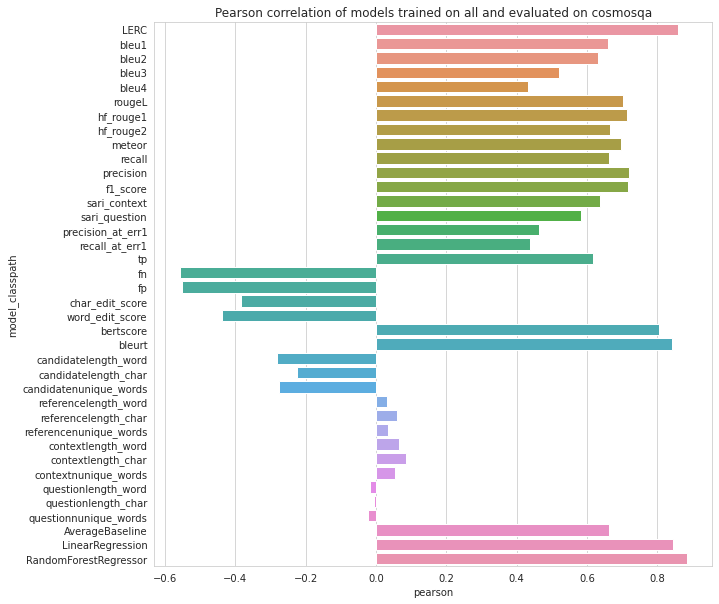

In [110]:
trained_on = "all"
evaluated_on = "cosmosqa"
d = all_results[
    (all_results["trained_on"] == trained_on)
    & (all_results["evaluated_on"] == evaluated_on)
]

plt.figure(figsize=(10, 10))
sns.barplot(data=d, y="model_classpath", x="pearson", orient="h")
plt.title(f"Pearson correlation of models trained on {trained_on} and evaluated on {evaluated_on}")

Text(0.5, 1.0, 'Pearson correlation of models trained on except_cosmosqa and evaluated on cosmosqa')

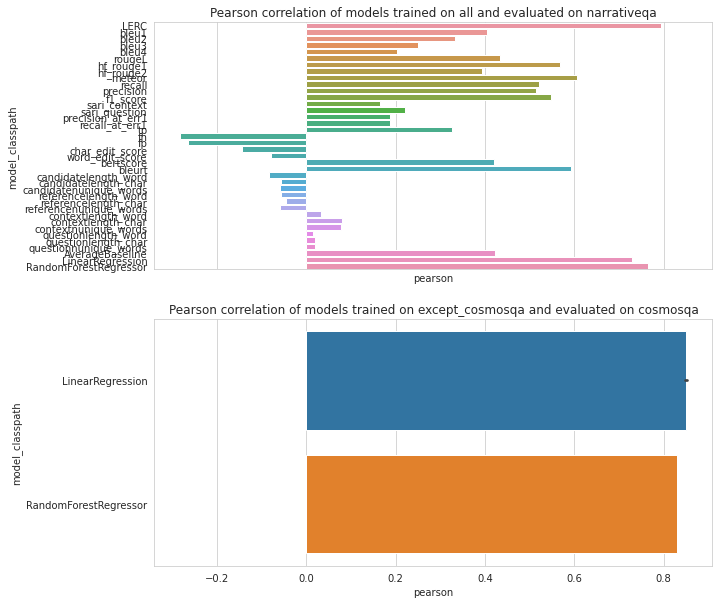

In [104]:
trained_on = "all"
evaluated_on = "narrativeqa"
d = all_results[
    (all_results["trained_on"] == trained_on)
    & (all_results["evaluated_on"] == evaluated_on)
]

fig, axes = plt.subplots(2, 1, sharex=True, figsize=(10, 10))
ax=axes[0]
sns.barplot(data=d, y="model_classpath", x="pearson", orient="h", ax=ax)
ax.set_title(f"Pearson correlation of models trained on {trained_on} and evaluated on {evaluated_on}")



trained_on = "except_cosmosqa"
evaluated_on = "cosmosqa"
d = all_results[
    (all_results["trained_on"] == trained_on)
    & (all_results["evaluated_on"] == evaluated_on)
]

ax=axes[1]
sns.barplot(data=d, y="model_classpath", x="pearson", orient="h", ax=ax)
ax.set_title(f"Pearson correlation of models trained on {trained_on} and evaluated on {evaluated_on}")

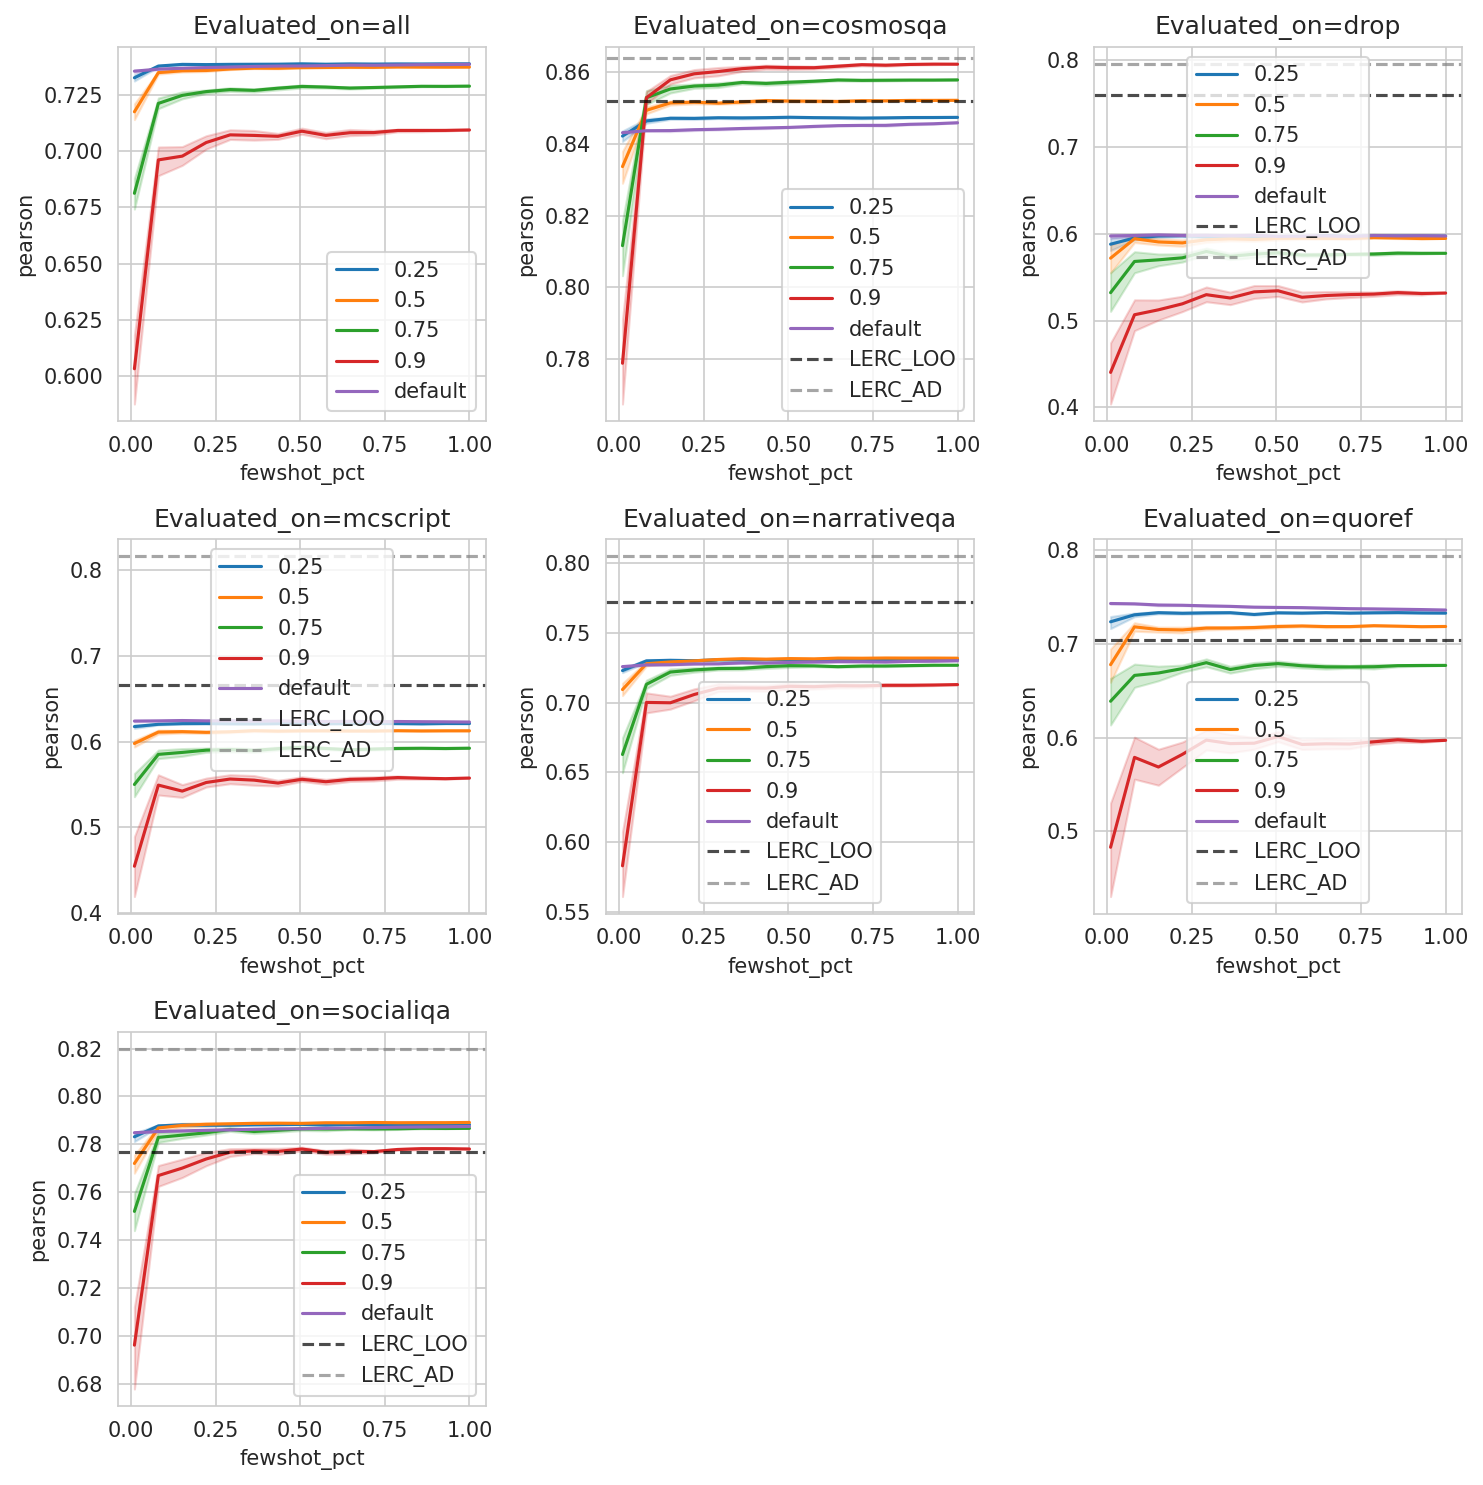

In [118]:
plot_fewshot_curve(loo_cosmosqa_results, "pearson")

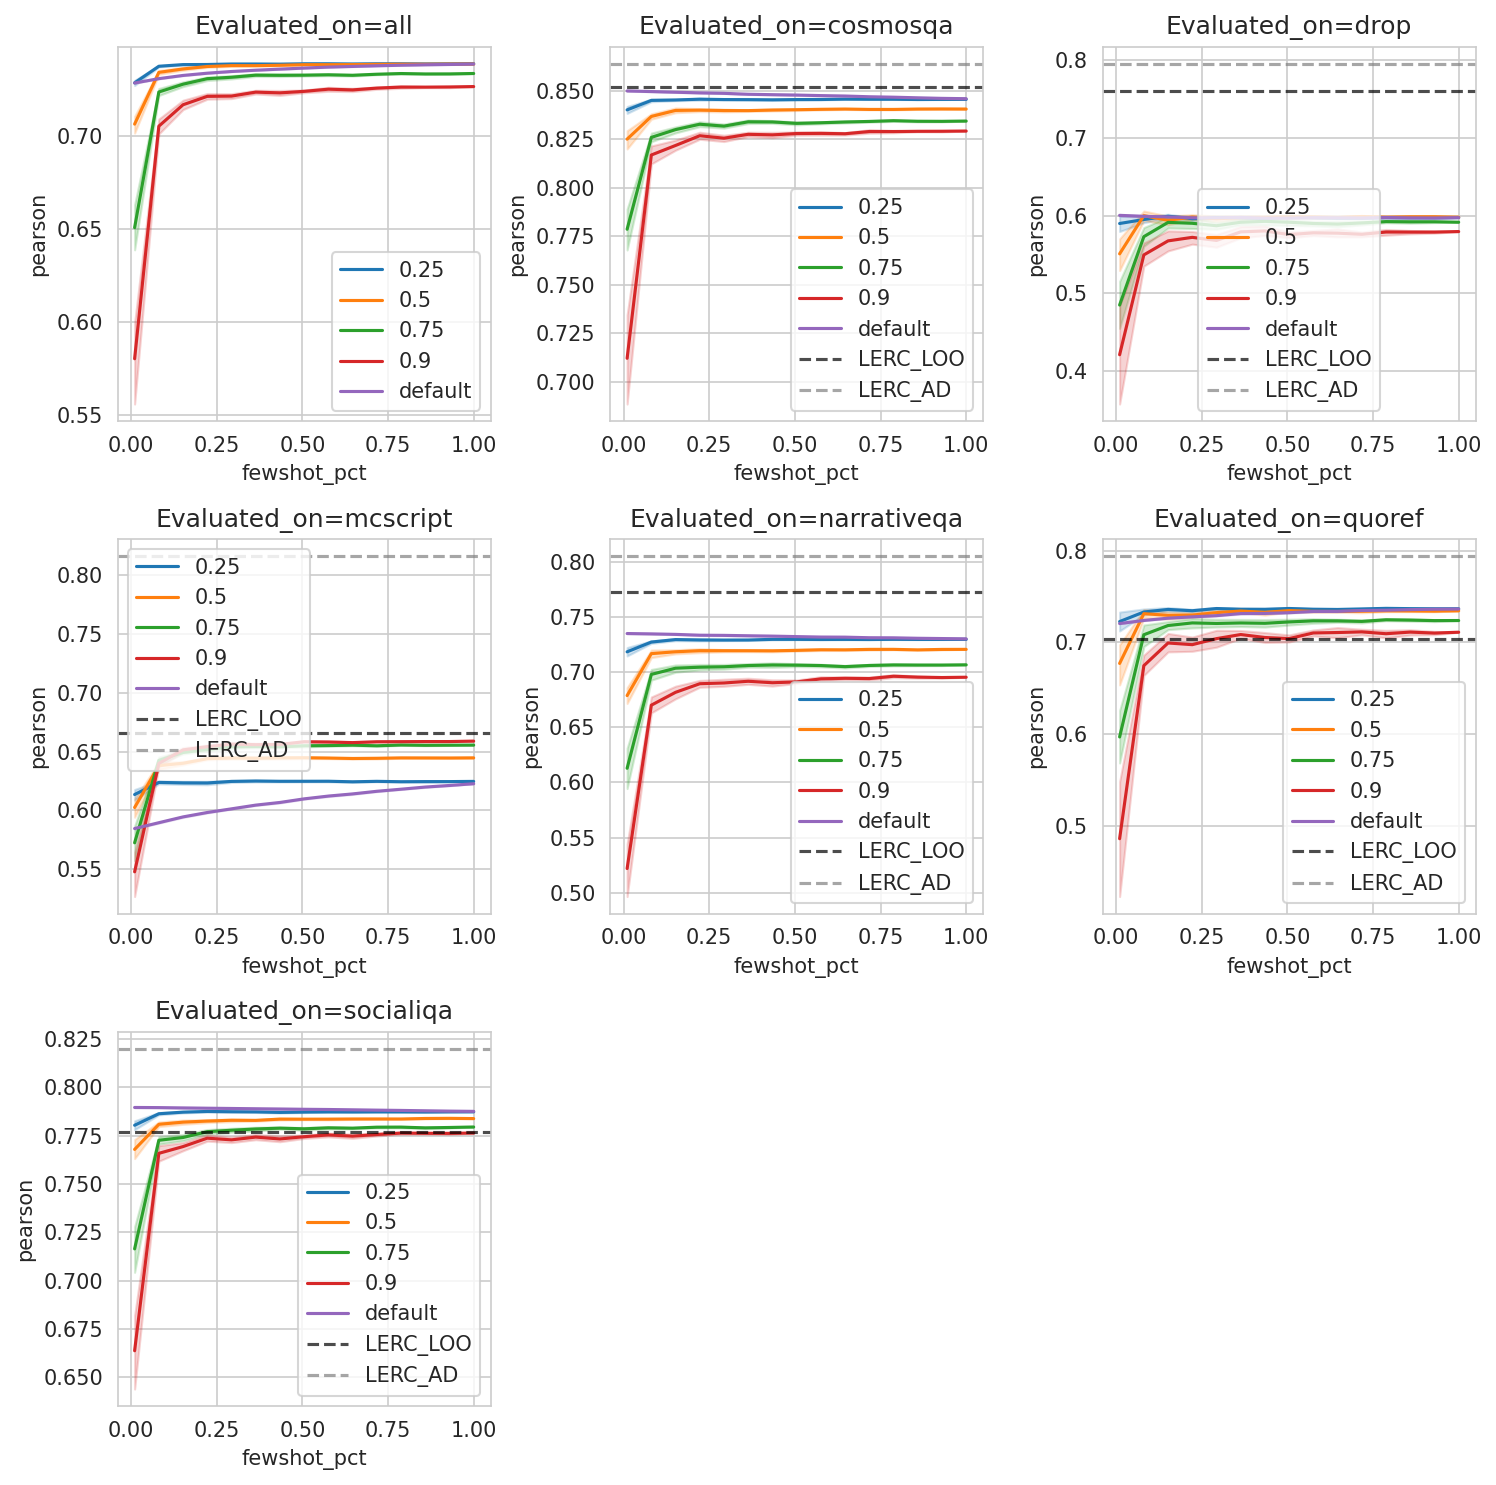

In [112]:
plot_fewshot_curve(loo_mcscript_results, "pearson")

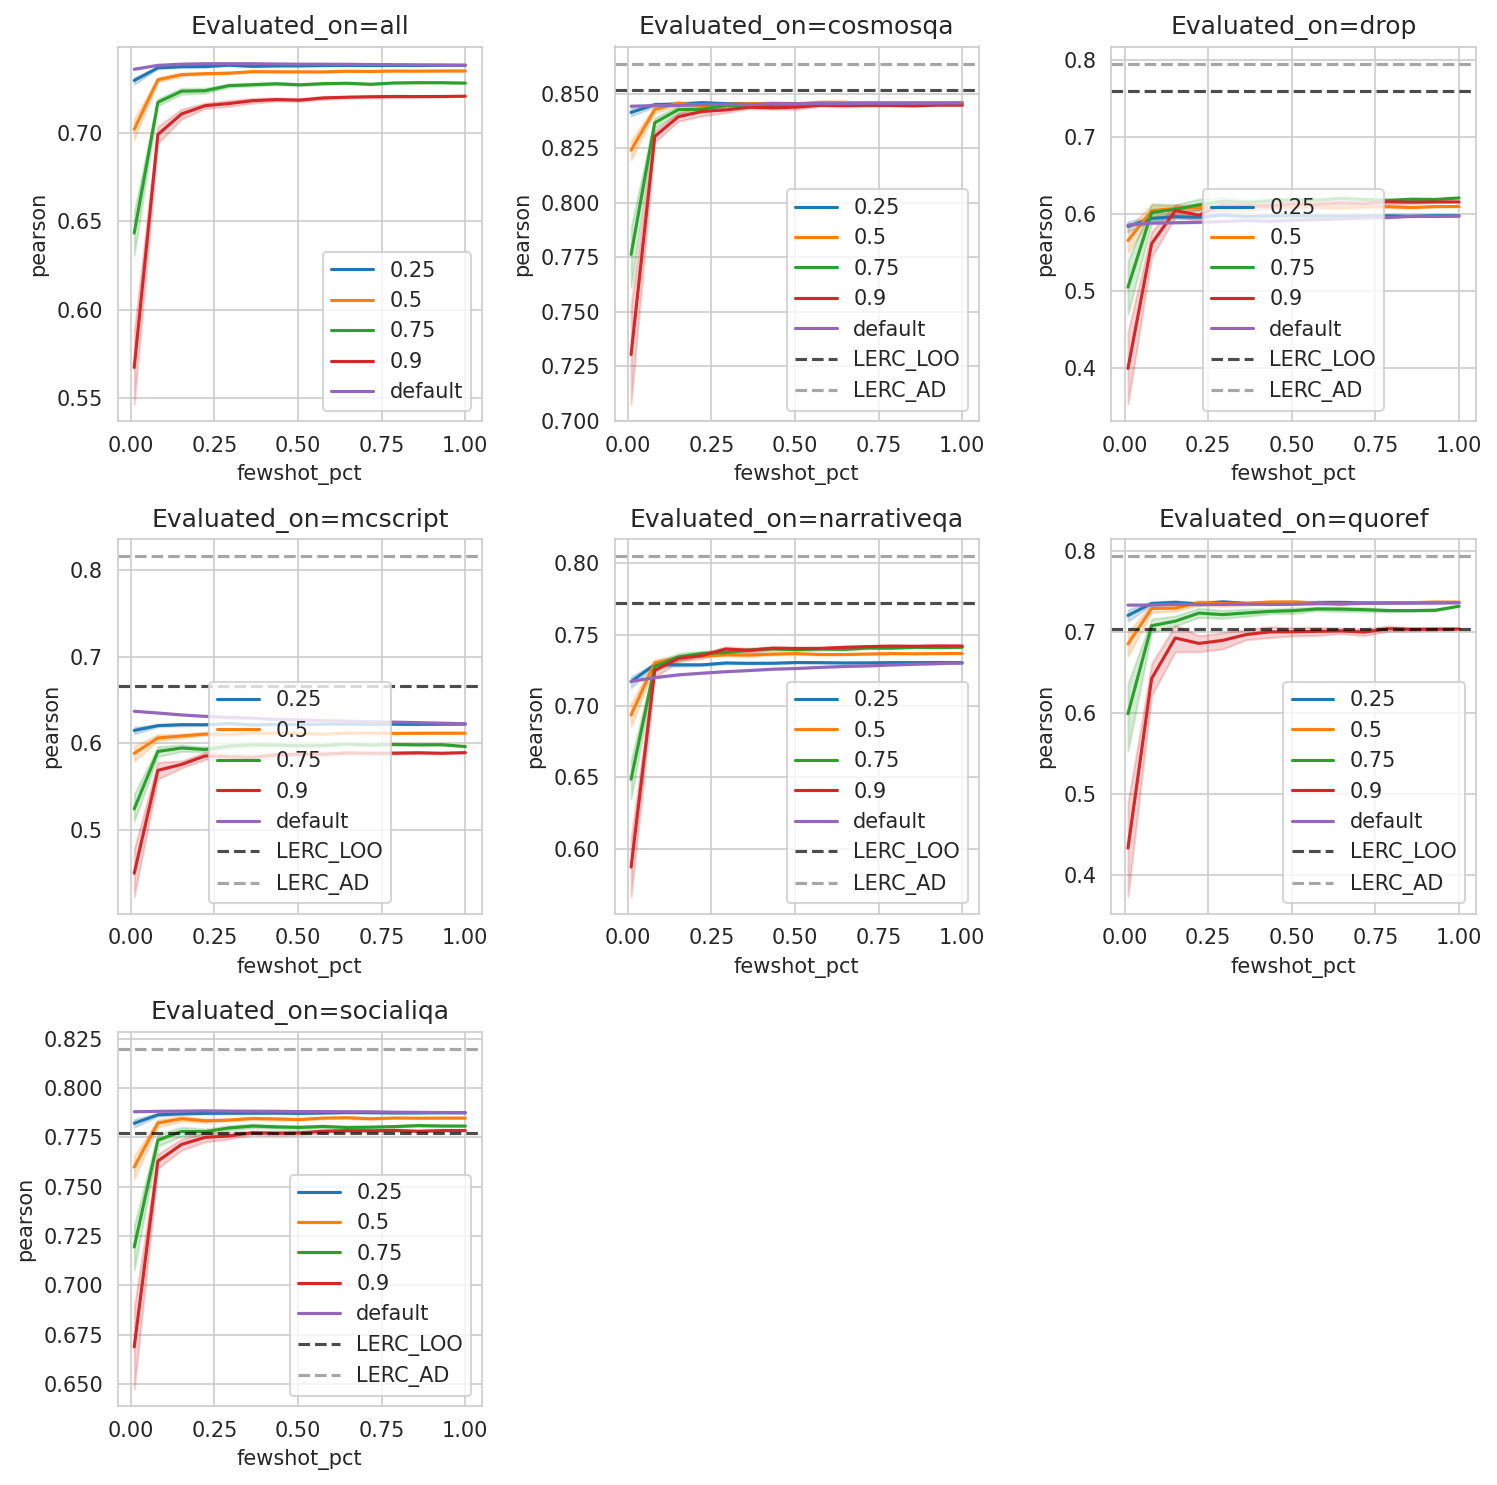

In [113]:
plot_fewshot_curve(loo_narrqa_results, "pearson")

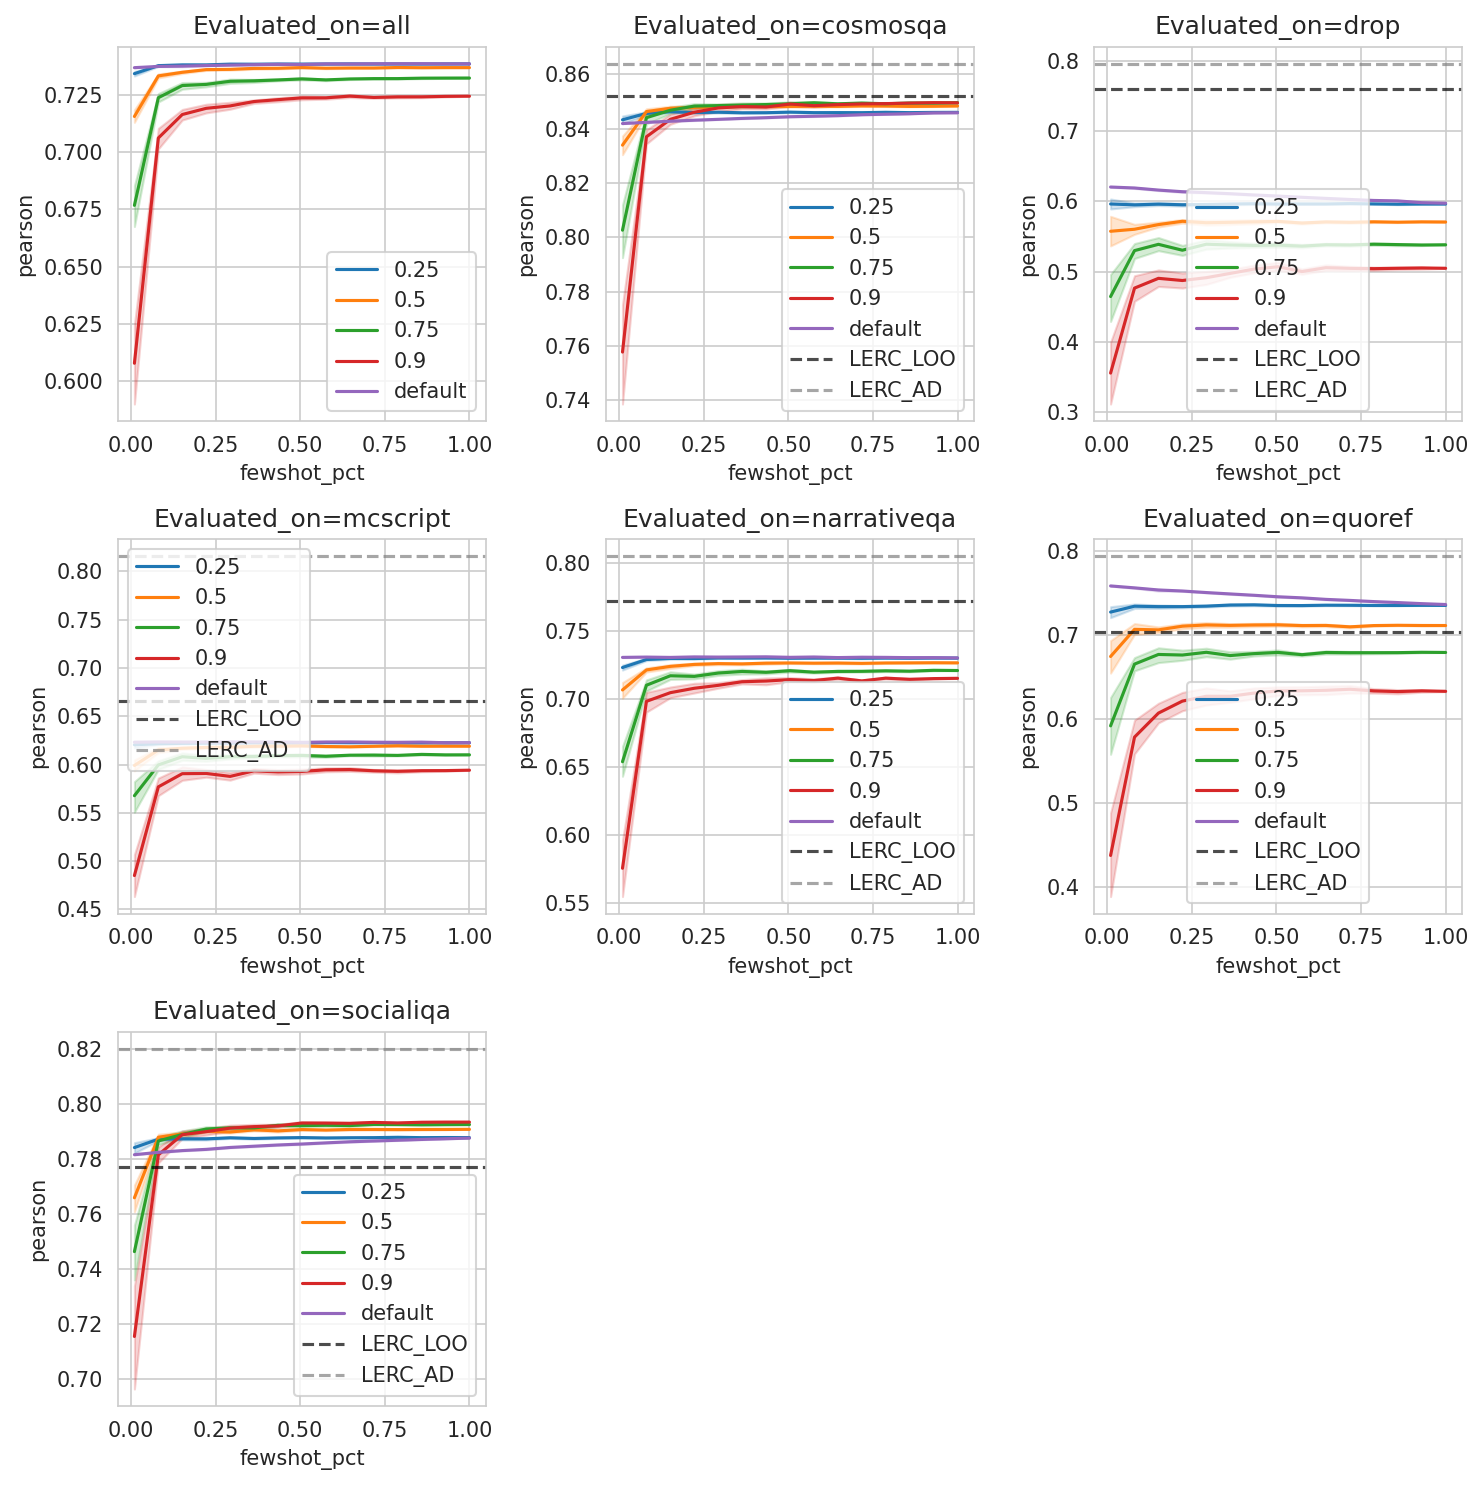

In [114]:
plot_fewshot_curve(loo_sociqa_results, "pearson")

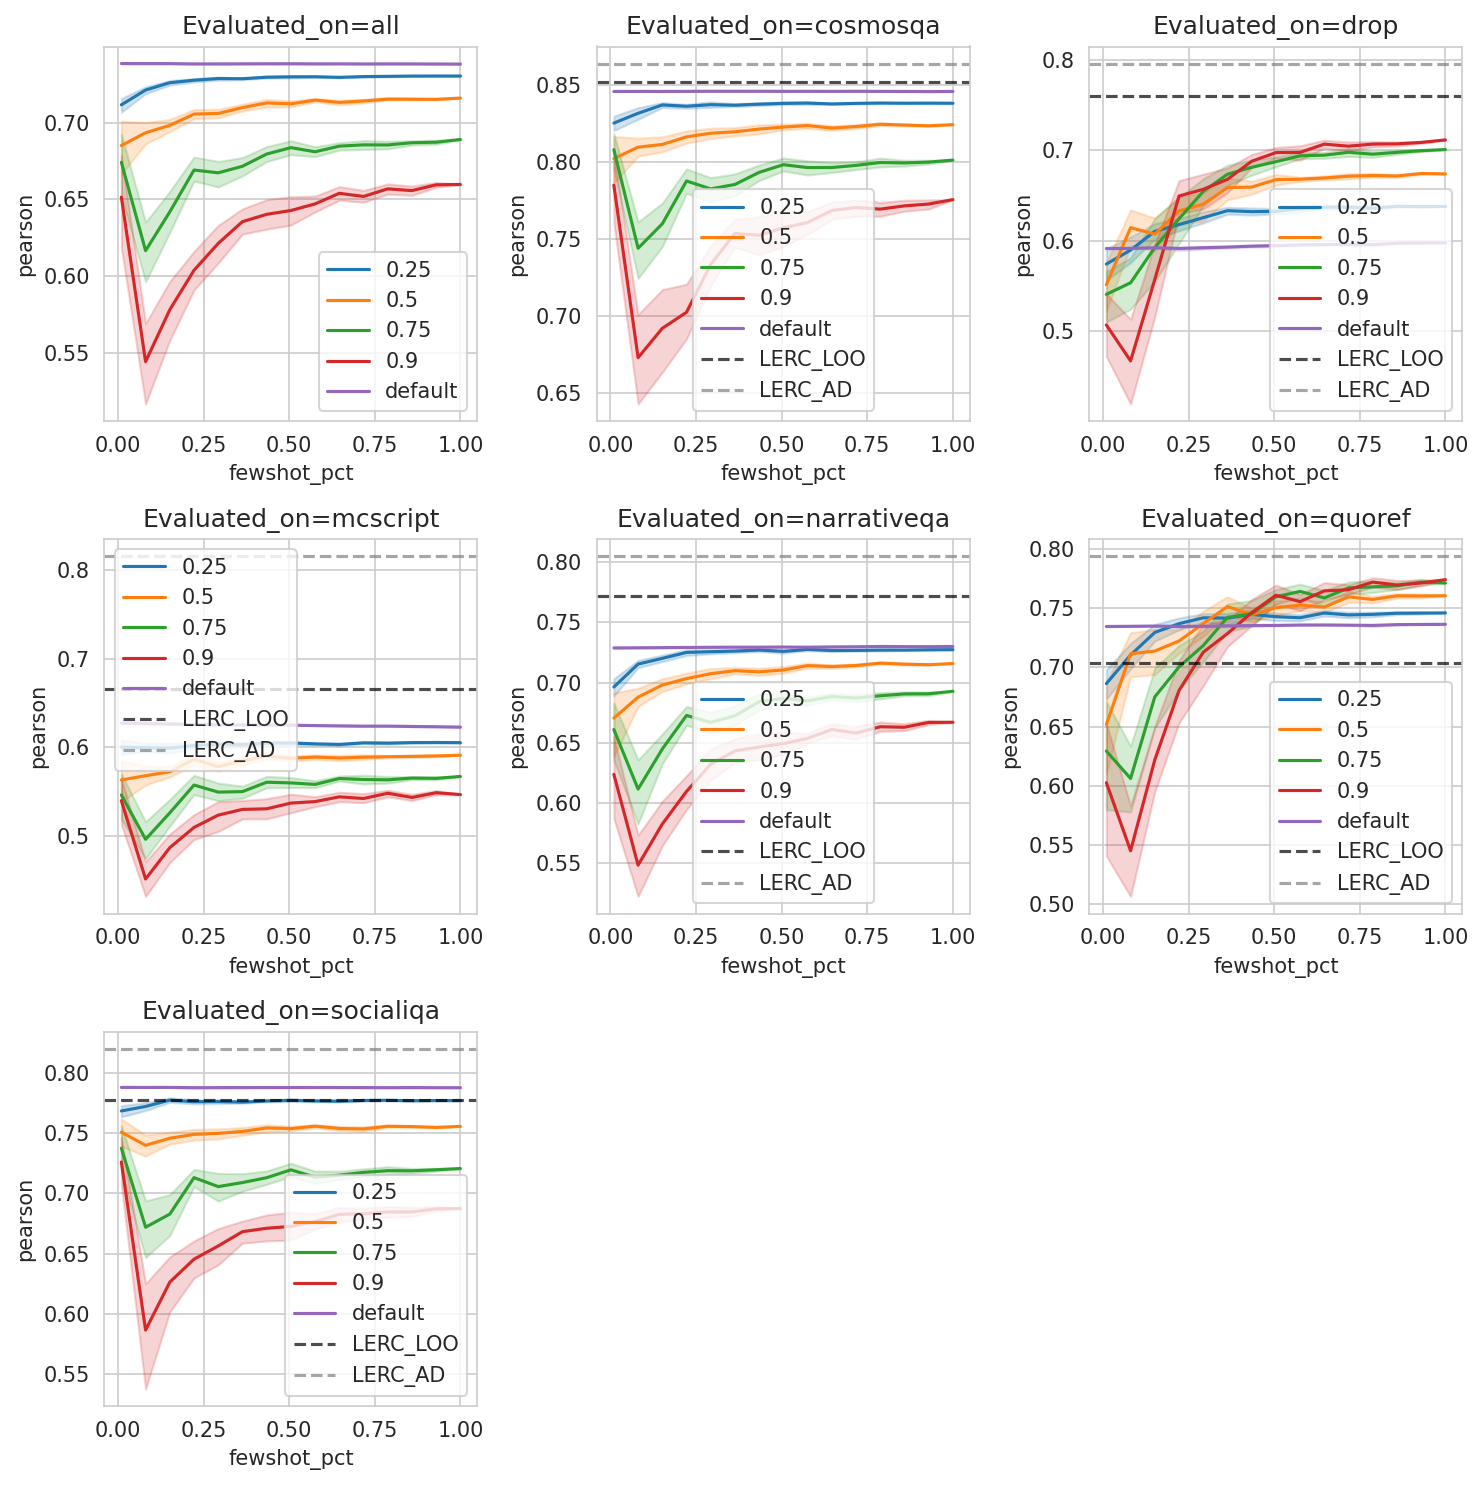

In [115]:
plot_fewshot_curve(loo_drop_results, "pearson")

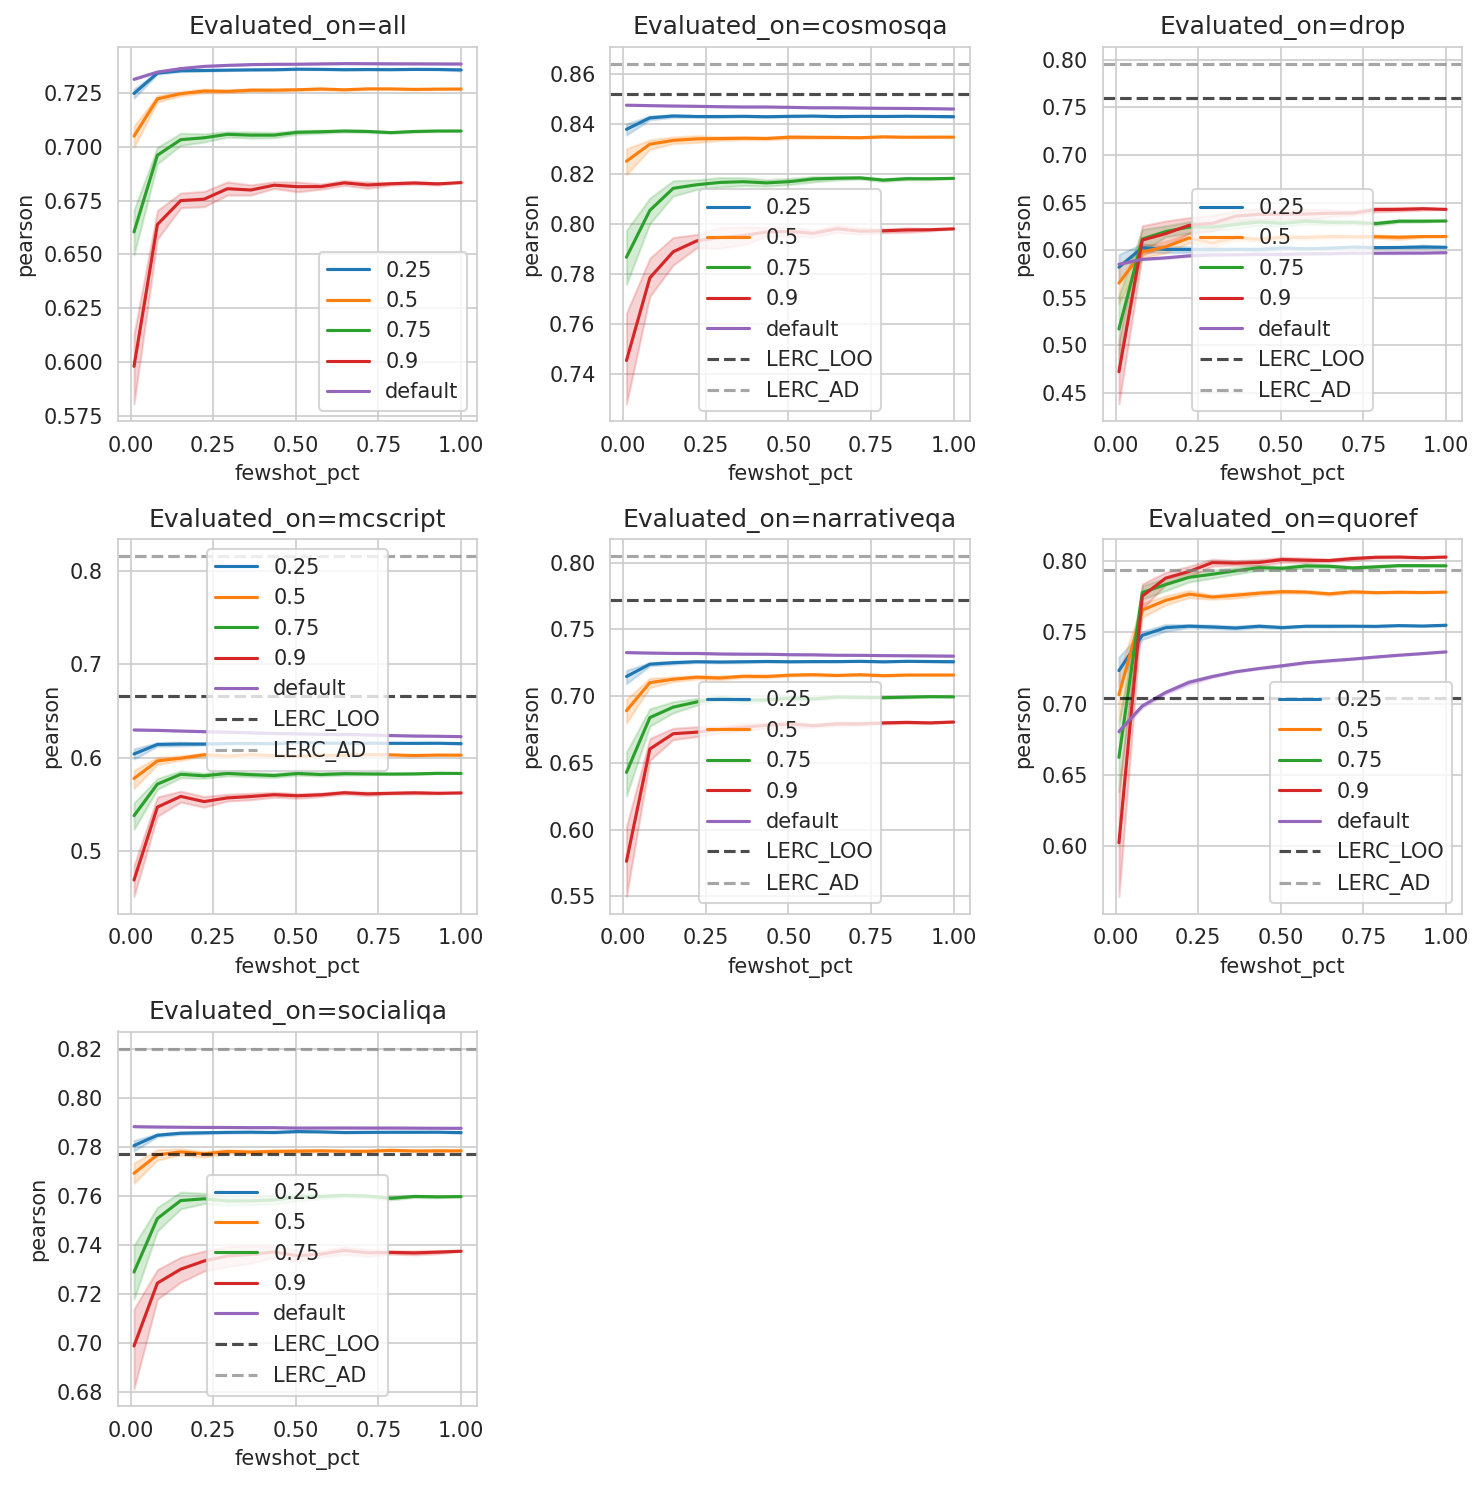

In [116]:
plot_fewshot_curve(loo_quoref_results, "pearson")